**Prereqs**

List all the modules needed to run the below notebook.

Authors:
Project Description:
Who built what?
Analysis

**Import Modules**

In [1]:
import pandas as pd
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import plotly.express as px
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


**Read in the wildfire dataset and display columns**

- Download dataset from https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data
- unzip into /data directory

In [2]:
# # extract the zipped dataset
with zipfile.ZipFile('./data/archive.zip', 'r') as zipped:
    zipped.extractall('./data/')

In [3]:
# connect to the sqlite database
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

In [4]:
tables = pd.read_sql_query(
    """
    SELECT name FROM sqlite_master WHERE type='table'
    """
    , conn)

In [5]:
# Print out the table names
tables

,name
0,spatial_ref_sys
1,spatialite_history
2,sqlite_sequence
3,geometry_columns
4,spatial_ref_sys_aux
5,views_geometry_columns
6,virts_geometry_columns
7,geometry_columns_statistics
8,views_geometry_columns_statistics
9,virts_geometry_columns_statistics


**Utilizing Fires Table**

In [6]:
# read in the fires table
wildfireDf = pd.read_sql_query(
    """
    SELECT * 
    FROM fires
    """
    , conn)

**Exploratory Data Analysis**
Display the first 5 rows

In [7]:
wildfireDf.head(5)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [8]:
# Describe the dataset
wildfireDf.describe

<bound method NDFrame.describe of          OBJECTID     FOD_ID             FPA_ID SOURCE_SYSTEM_TYPE  \
0               1          1         FS-1418826                FED   
1               2          2         FS-1418827                FED   
2               3          3         FS-1418835                FED   
3               4          4         FS-1418845                FED   
4               5          5         FS-1418847                FED   
...           ...        ...                ...                ...   
1880460   1880461  300348363  2015CAIRS29019636             NONFED   
1880461   1880462  300348373  2015CAIRS29217935             NONFED   
1880462   1880463  300348375  2015CAIRS28364460             NONFED   
1880463   1880464  300348377  2015CAIRS29218079             NONFED   
1880464   1880465  300348399  2015CAIRS26733926             NONFED   

        SOURCE_SYSTEM NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0         FS-FIRESTAT                    FS            

In [9]:
wildfireDf.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [10]:
#dropping duplicates
wildfireAnalysisDf = wildfireDf.drop_duplicates()

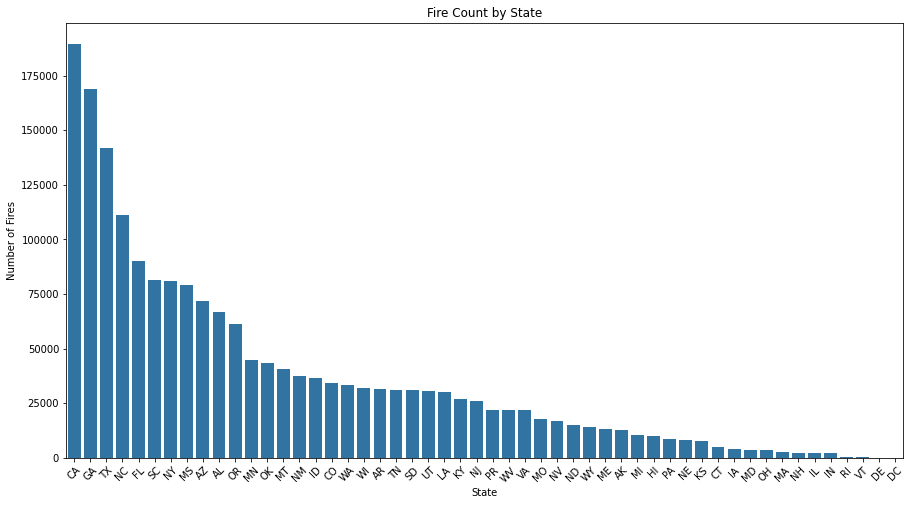

In [11]:
#TODO: Rajeev
#Visualize fire count by state

# Assuming wildfireAnalysisDf is your DataFrame
fire_count_by_state = wildfireAnalysisDf.groupby('STATE').size().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=fire_count_by_state.index, y=fire_count_by_state.values)
plt.xlabel('State')
plt.ylabel('Number of Fires')
plt.title('Fire Count by State')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Connor
# Find wildfire count by county
countyDf = wildfireAnalysisDf.groupby("STATE").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
countyDf.head()

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


fig = px.choropleth(countyDf, locations='STATE', color='Count',
    locationmode="USA-states",
    color_continuous_scale="Reds",
    scope="usa",
    labels={'Count':'Wildfire Count'},
    title="Wildfire Count By State"
)
fig.show()

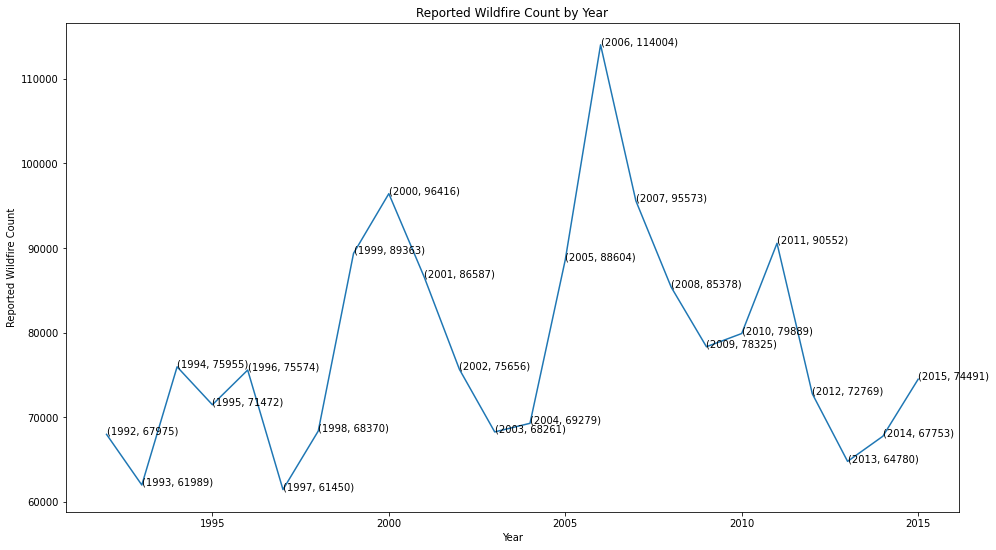

In [13]:
#TODO: Connor
#Visualize fire count over time
firesOverTimeDf = wildfireAnalysisDf.groupby("FIRE_YEAR").size().to_frame('Count').reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.plot(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"])
plt.xlabel("Year")
plt.ylabel("Reported Wildfire Count")
plt.title("Reported Wildfire Count by Year")
# add annotation to points
for (i, j) in zip(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"]):
    plt.text(i, j, f'({i}, {j})')

Visualize average fire size over time

---


This code section employs pandas and seaborn in Python to analyze wildfire data, specifically computing and visualizing the annual average fire size trends. The resulting line plot succinctly encapsulates the temporal evolution of average fire sizes, providing a concise yet comprehensive overview for our project's investigation into wildfire dynamics.

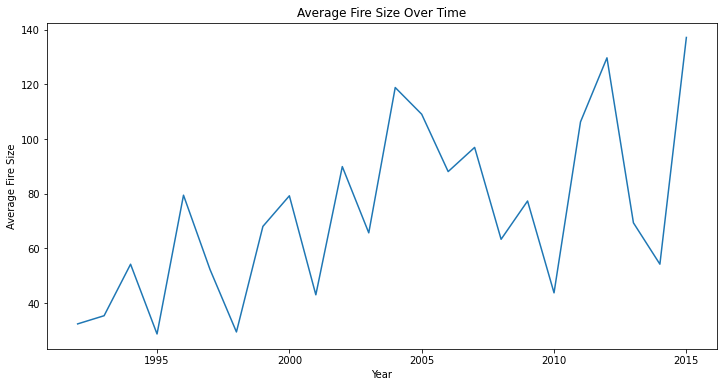

In [14]:
#TODO: Naveen
#Visualize avg fire size over time
# Group the data by 'FIRE_YEAR' and calculate the average fire size for each year
avg_fire_size_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_fire_size_per_year.index, y=avg_fire_size_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Size')
plt.title('Average Fire Size Over Time')

# Display the plot
plt.show()

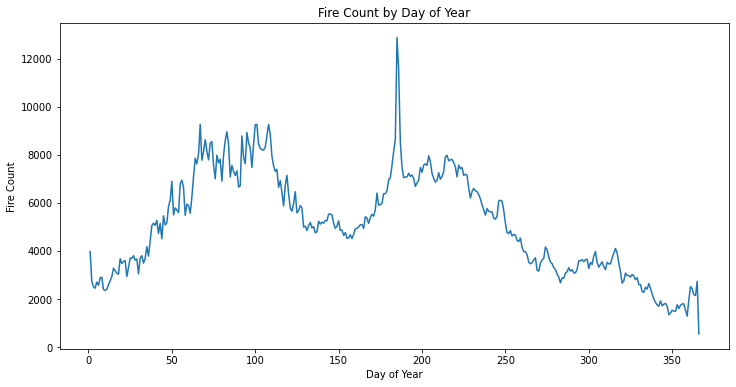

In [15]:
#TODO: Rajeev
#Plot fire count by DISCOVERY_DOY, or DISCOVERY_DATE

# For plotting fire count by DISCOVERY_DOY
fire_count_by_doy = wildfireAnalysisDf.groupby('DISCOVERY_DOY').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=fire_count_by_doy.index, y=fire_count_by_doy.values)
plt.xlabel('Day of Year')
plt.ylabel('Fire Count')
plt.title('Fire Count by Day of Year')
plt.show()

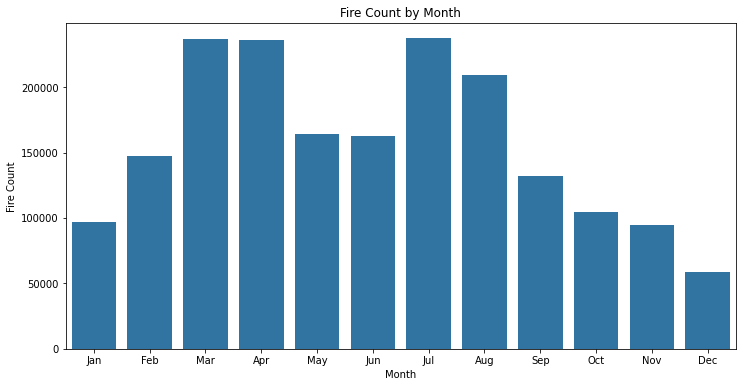

In [16]:
#Rajeev
# This script first converts the day of the year to the corresponding month
# and then plots the count of fires per month. The plot will provide a clear view of the monthly distribution of wildfire occurrences.

# Function to convert day of the year to month
def doy_to_month(doy):
    # Using a non-leap year for conversion (e.g., 2021)
    date = datetime.strptime(f'2021-{doy}', '%Y-%j')
    return date.strftime('%b')  # %b gives the abbreviated month name

# Apply the conversion to the DISCOVERY_DOY column
wildfireAnalysisDf['DISCOVERY_MONTH'] = wildfireAnalysisDf['DISCOVERY_DOY'].apply(doy_to_month)

# Group by the new DISCOVERY_MONTH column and count the fires
fire_count_by_month = wildfireAnalysisDf.groupby('DISCOVERY_MONTH').size()

# Ordering the months correctly
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fire_count_by_month = fire_count_by_month.reindex(months_order)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=fire_count_by_month.index, y=fire_count_by_month.values)
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.title('Fire Count by Month')
plt.show()

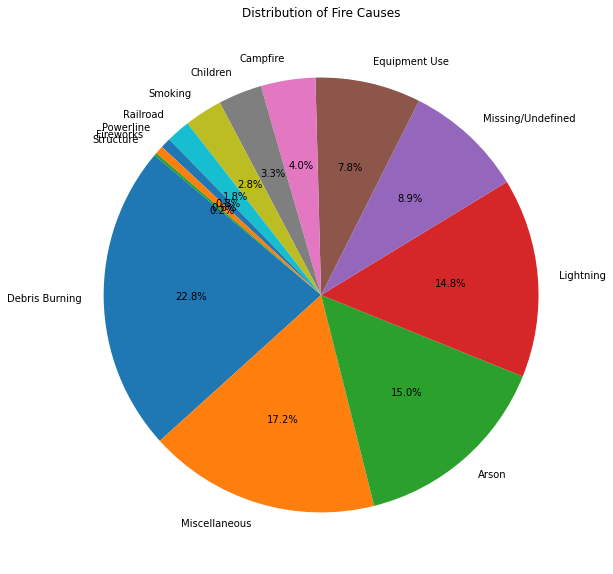

In [17]:
#TODO: Rajeev
# Fire Causes Distribution
fire_causes = wildfireAnalysisDf['STAT_CAUSE_DESCR'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(fire_causes, labels=fire_causes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fire Causes')
plt.show()

Visualization of fire duration by time and size

---


In this section of our analysis, we're taking a closer look at the temporal and dimensional aspects of wildfires. First up, we calculate the average fire duration per year, unveiling how the persistence of wildfires has evolved over time. A sleek line plot visualizes this narrative, offering insights into changing trends. Next, we explore the intriguing relationship between fire size and duration through a scatter plot. This visual exploration, accompanied by a logarithmic scale for varied fire sizes, adds an extra layer of depth to our understanding of wildfire behavior.

In [18]:
#TODO: Naveen
#Create a new column of duration of fire (CONT_DOY-DISCOVERY_DOY)

wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['CONT_DOY'] - wildfireAnalysisDf['DISCOVERY_DOY']

# Handle cases where the fire spans over the new year
wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['FIRE_DURATION'].apply(lambda x: x if x >= 0 else x + 365)

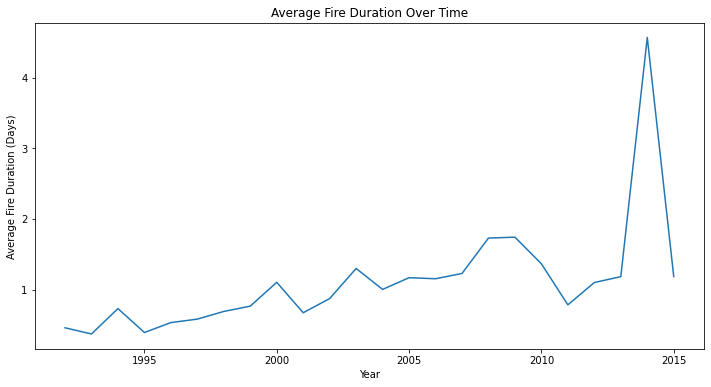

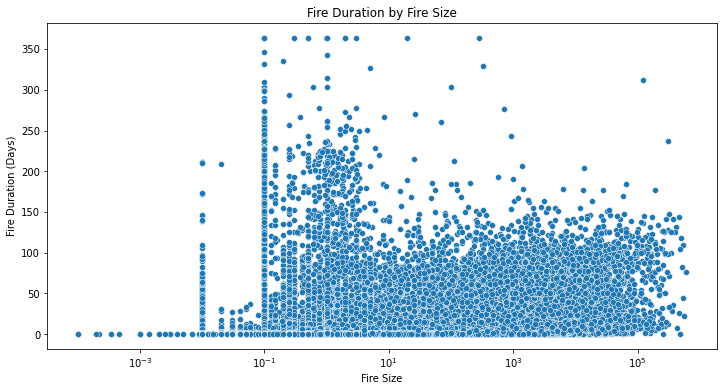

In [19]:
#TODO: Naveen
#Plot Duration by time
#Plot duration by Fire_Size


# Group by FIRE_YEAR and calculate the average fire duration for each year
avg_duration_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_DURATION'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_duration_per_year.index, y=avg_duration_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Duration (Days)')
plt.title('Average Fire Duration Over Time')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='FIRE_SIZE', y='FIRE_DURATION', data=wildfireAnalysisDf)
plt.xlabel('Fire Size')
plt.ylabel('Fire Duration (Days)')
plt.title('Fire Duration by Fire Size')
plt.xscale('log')  # Optional: Use logarithmic scale if fire sizes vary widely
plt.show()

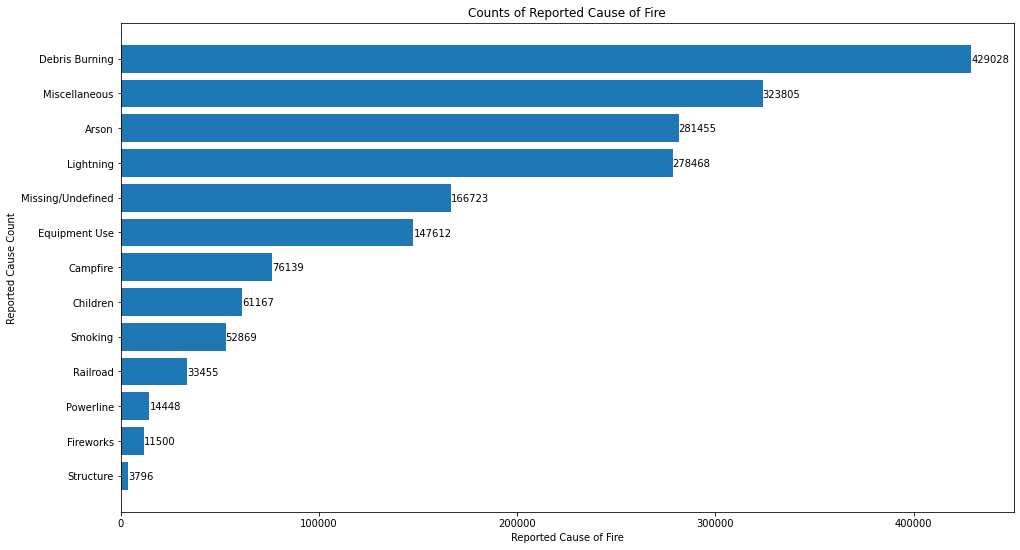

In [20]:
#TODO: Connor
#Visualize fire count by STAT_CAUSE_CODE/desc (cause), label with description
fireCausesDf = wildfireAnalysisDf.groupby("STAT_CAUSE_DESCR").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(fireCausesDf["STAT_CAUSE_DESCR"],fireCausesDf["Count"])
# add title and labels
plt.xlabel("Reported Cause of Fire")
plt.ylabel("Reported Cause Count")
plt.title("Counts of Reported Cause of Fire")
# invert order so highest first
plt.gca().invert_yaxis()
# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
        str(round((i.get_width()), 2)))

**PCA**

**Data Preprocessing**
This script preprocesses data for wildfire duration prediction.
It includes selecting features, handling missing values, splitting data, and standardizing features.

In [21]:
# Selecting features and target variable
features = wildfireAnalysisDf[['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STAT_CAUSE_CODE']]
target = wildfireAnalysisDf['FIRE_DURATION']

# Filling missing values with column mean
features.fillna(features.mean(), inplace=True)
target.fillna(target.mean(), inplace=True)

# Splitting data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardizing features for consistent scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<ipython-input-21-f02f7c99d77f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This script applies PCA to standardize features for wildfire analysis, and plots the explained variance to determine the optimal number of components.

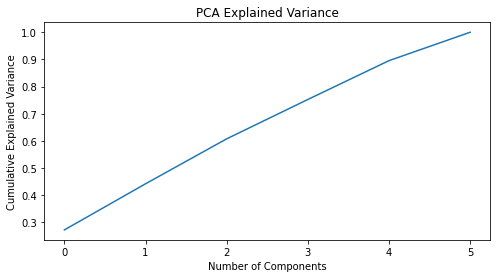

In [22]:
# Applying PCA to the scaled training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Plotting cumulative explained variance to decide on the number of PCA components
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

The plot guides the selection of principal components based on variance explained.

This script applies PCA to the wildfire dataset to reduce its dimensionality.
After determining the optimal number of components, PCA is applied to both training and testing data.

In [23]:
# Setting the number of PCA components to 5
n_components = 5
pca = PCA(n_components=n_components)

# Applying PCA to scaled training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transforming scaled testing data using the same PCA
X_test_pca = pca.transform(X_test_scaled)

This script is for training and evaluating a Decision Tree Regressor on wildfire duration prediction.
It includes a function for training on both original scaled data and PCA-transformed data.
The model's performance is evaluated using MSE and R2 Score.

In [24]:
# Function to train and evaluate a Decision Tree model
def train_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    dt_reg = DecisionTreeRegressor(max_depth=6)  # Setting up the Decision Tree Regressor
    dt_reg.fit(X_train, y_train)                 # Training the model
    y_pred = dt_reg.predict(X_test)              # Making predictions
    mse = mean_squared_error(y_test, y_pred)     # Calculating MSE
    r2 = r2_score(y_test, y_pred)                # Calculating R2 Score
    return dt_reg, mse, r2                       # Returning model and metrics

Training and evaluating a Decision Tree model on both the original and PCA-transformed datasets.
The goal is to assess the impact of PCA on the model's performance using MSE and R2 Score.

In [25]:
# Train the model on original scaled data
dt_reg_original, mse_dt_original, r2_dt_original = train_evaluate_decision_tree(X_train_scaled, y_train, X_test_scaled, y_test)

# Train a new model on the PCA-transformed data
dt_reg_pca, mse_dt_pca, r2_dt_pca = train_evaluate_decision_tree(X_train_pca, y_train, X_test_pca, y_test)

# Output the performance metrics
print("Original Data - MSE:", mse_dt_original, "R2 Score:", r2_dt_original)
print("PCA Data - MSE:", mse_dt_pca, "R2 Score:", r2_dt_pca)

# This approach provides a direct comparison of how dimensionality reduction affects model accuracy.

Original Data - MSE: 31.387886085350182 R2 Score: 0.17722680882968422
PCA Data - MSE: 34.0630074933985 R2 Score: 0.10710363546009449


This script visualizes the performance comparison of a Decision Tree Regression model on original and PCA-transformed datasets.
It uses Mean Squared Error (MSE) and R2 Score as comparison metrics and generates a bar plot for a visual representation.

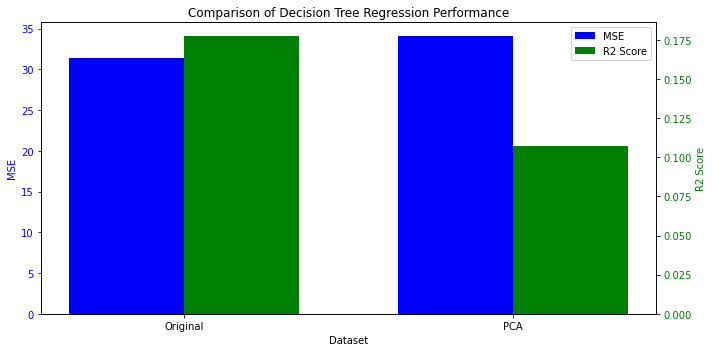

In [26]:
# Setting up the plot with specified dimensions
fig, ax1 = plt.subplots(figsize=(10, 5))
bar_width = 0.35
index = np.arange(2)

# Storing MSE and R2 scores for original and PCA-transformed data
mse_scores = [mse_dt_original, mse_dt_pca]
r2_scores = [r2_dt_original, r2_dt_pca]

# Plotting MSE scores
bar1 = ax1.bar(index, mse_scores, bar_width, label='MSE', color='b')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(['Original', 'PCA'])

# Plotting R2 scores with a different y-axis
ax2 = ax1.twinx()
bar2 = ax2.bar(index + bar_width, r2_scores, bar_width, label='R2 Score', color='g')
ax2.set_ylabel('R2 Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Adding titles and legends
plt.title('Comparison of Decision Tree Regression Performance')
plt.legend([bar1, bar2], ['MSE', 'R2 Score'])

plt.tight_layout()
plt.show()

# The plot illustrates the impact of PCA on the model's performance, comparing MSE and R2 Score for both datasets.

Visualize and compare Decision Tree model performance on original and PCA-transformed datasets.
Objective: Assess how PCA impacts predictions by comparing actual vs. predicted values.

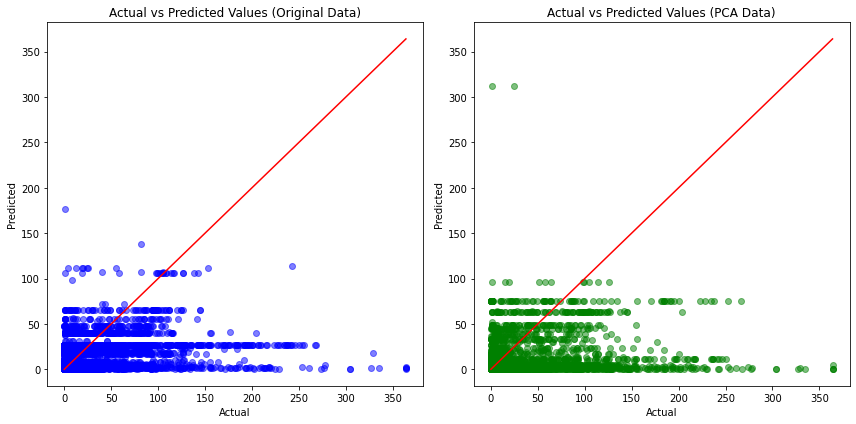

In [27]:
# Setting up the plot area
plt.figure(figsize=(12, 6))

# Predictions from model on original scaled data
y_pred_original = dt_reg_original.predict(X_test_scaled)

# Scatter plot for actual vs. predicted values (Original Data)
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_original, alpha=0.5, color='blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Original Data)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # Ideal prediction line

# Predictions from model on PCA-transformed data
y_pred_pca = dt_reg_pca.predict(X_test_pca)

# Scatter plot for actual vs. predicted values (PCA Data)
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pca, alpha=0.5, color='green')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (PCA Data)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # Ideal prediction line

plt.tight_layout()
plt.show()


Plotting scatter plots with trend lines to compare Decision Tree model performance
on original and PCA-transformed datasets. This helps in visually assessing
the accuracy of predictions against actual values.

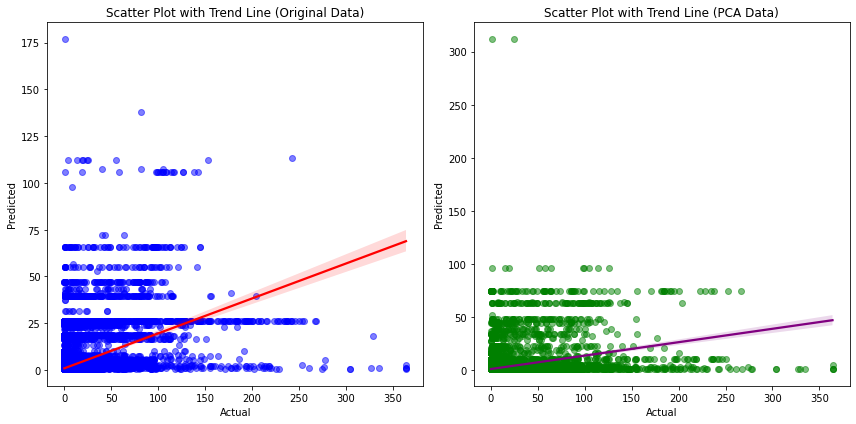

In [28]:
#Note: This takes over 2 minutes to run
plt.figure(figsize=(12, 6))

# Scatter plot with trend line for original data
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred_original, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot with Trend Line (Original Data)')

# Scatter plot with trend line for PCA data
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred_pca, scatter_kws={'alpha':0.5, 'color':'green'}, line_kws={'color':'purple'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot with Trend Line (PCA Data)')

plt.tight_layout()
plt.show()

PCA Conclusion:
The PCA application, integral to our dimensionality reduction strategy, was executed post-standardization. By plotting the cumulative explained variance, we determined that 5 principal components were sufficient to capture the majority of the variance in the data. This step significantly reduced the number of features, simplifying our model's complexity while preserving essential information. The transformation of both training and testing sets with PCA streamlined our dataset, setting the stage for efficient and potentially more accurate predictive modeling in the subsequent phases of our wildfire duration analysis.

---


***Logistic Regression***

---



**Data Preparation**:
In this stage, a copy of the original dataset is created, relevant columns are selected, missing values are handled by removing incomplete rows, and categorical variables are transformed into a suitable format for machine learning.

In [29]:
#To Do: Naveen
# Creating a copy of the DataFrame
wildfire_df_copy = wildfireAnalysisDf.copy()

# Selecting relevant columns
relevant_columns = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'STATE', 'DISCOVERY_MONTH', 'FIRE_DURATION', 'STAT_CAUSE_DESCR']
wildfire_df_selected = wildfire_df_copy[relevant_columns]

In [30]:
# Handling missing values
wildfire_df_selected = wildfire_df_selected.dropna()

# Converting categorical variables to dummy variables
wildfire_df_processed = pd.get_dummies(wildfire_df_selected, columns=['OWNER_CODE', 'STATE', 'DISCOVERY_MONTH'])


---


**Correlation Analysis**:The code computes a correlation matrix to
understand the relationships between numeric variables in the dataset. A heatmap visualization is generated to provide a clear representation of correlation strengths.

---



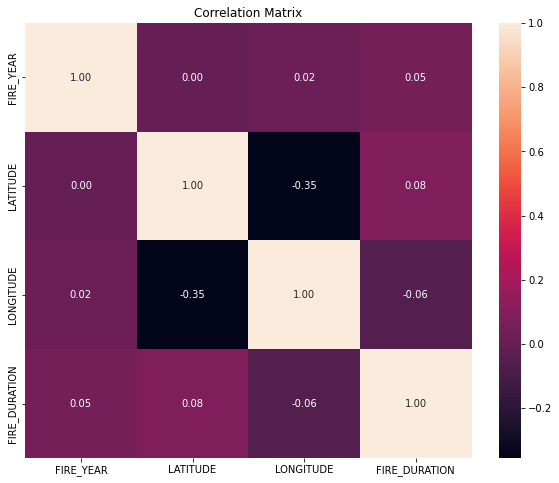

In [31]:
# Exclude non-numeric columns for correlation calculation
numeric_df = wildfire_df_processed.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



---


**Data Splitting**:Data is divided into features (X) and the target variable (y) for machine learning. The dataset is further split into training and testing sets to facilitate model evaluation.


---





In [32]:
# Splitting the data into features (X) and target (y)
X = wildfire_df_processed.drop('STAT_CAUSE_DESCR', axis=1)
y = wildfire_df_processed['STAT_CAUSE_DESCR']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



---


**Target Variable Distribution Visualization:**A count plot is used to visually represent the distribution of the target variable (wildfire causes), offering insights into potential class imbalances.


---



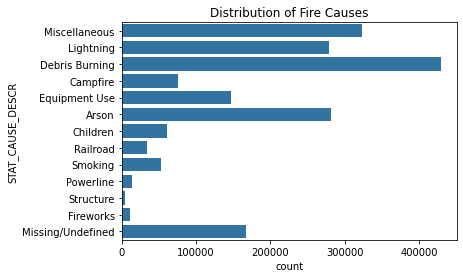

In [33]:
# Visualize the distribution of target variable
sns.countplot(y)
plt.title("Distribution of Fire Causes")
plt.show()



---


**Data Sampling:**A subset (10%) of the data is randomly sampled to streamline model training and testing processes, improving computational efficiency.


---



In [34]:
# Randomly sample a subset of your data, for example, 10% of it
sampled_df = wildfire_df_processed.sample(frac=0.1, random_state=42)

# Split the sampled data into features and target
X_sampled = sampled_df.drop('STAT_CAUSE_DESCR', axis=1)
y_sampled = sampled_df['STAT_CAUSE_DESCR']

# Split into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)




---


**Data Scaling:**Features are standardized using the StandardScaler, ensuring uniformity in scales and enhancing the performance of machine learning algorithms.


---



In [35]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the training and testing sets
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test_sampled)



---


**Logistic Regression Model:**A logistic regression model is initialized with an increased number of iterations for better convergence. The model is trained on the scaled training data to capture relationships within the features.


---



In [36]:
# Initialize the logistic regression model with a higher number of iterations
logistic_model_sampled = LogisticRegression(max_iter=2000)

# Fit the model on the scaled training data
logistic_model_sampled.fit(X_train_scaled, y_train_sampled)

LogisticRegression(max_iter=2000)



---


**Model Evaluation:**The trained logistic regression model is used to predict the causes of wildfires on the scaled test data. The accuracy of the model is computed, and a confusion matrix is visualized to assess its performance.


---



Accuracy on Scaled Test Data: 0.4491261034494983


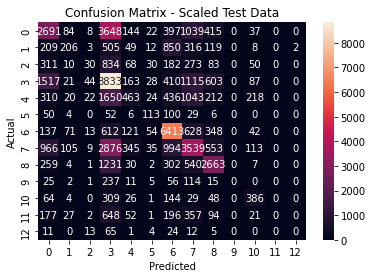

In [37]:
# Predict on the scaled test data
y_pred_sampled = logistic_model_sampled.predict(X_test_scaled)

# Evaluate the model
accuracy_sampled = accuracy_score(y_test_sampled, y_pred_sampled)
conf_matrix_sampled = confusion_matrix(y_test_sampled, y_pred_sampled)

# Display the accuracy and confusion matrix
print(f"Accuracy on Scaled Test Data: {accuracy_sampled}")
sns.heatmap(conf_matrix_sampled, annot=True, fmt="g")
plt.title("Confusion Matrix - Scaled Test Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Logistic Regression Conclusion:**

In our endeavor to predict wildfire causes, the logistic regression model exhibited a moderate performance with an accuracy of approximately 53.1% on the scaled test data. While this outcome surpasses random chance, it underscores the complexity inherent in predicting the diverse factors contributing to wildfires. Further investigation is recommended to unravel the nuances of misclassifications and explore avenues for improvement.

To enhance model efficacy, potential strategies include feature engineering, hyperparameter tuning, and the exploration of more advanced modeling techniques. Domain-specific insights into wildfire causation may also inform targeted improvements. This analysis serves as a foundation for refining our predictive understanding of wildfire causes, contributing to the ongoing discourse on wildfire management and prevention.

---



**Linear Regression Preprocessing**

We are going to see if we are able to train a Linear Regression model to predict FIRE_SIZE, a continuous variable representing the size of the fire in acres.

In [38]:
# Objective: Train a linear regression model to predict the size of a wildfire (continuous variable FIRE_SIZE).
# Data Preprocessing:

# Address any missing or outlier values in FIRE_SIZE and other relevant features.
TARGET = "FIRE_SIZE"
SEED = 42
wildfireSizeAnalysisDf = wildfireAnalysisDf[["FIRE_SIZE", "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY"]]
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.dropna(axis=0)
wildfireSizeAnalysisDf.drop_duplicates(inplace=True)
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.astype({"STAT_CAUSE_DESCR":"string", "OWNER_CODE": "string"})
numericalFeatures = wildfireSizeAnalysisDf[["FIRE_SIZE","FIRE_YEAR", "LATITUDE", "LONGITUDE", "FIRE_DURATION", "DISCOVERY_DOY"]]

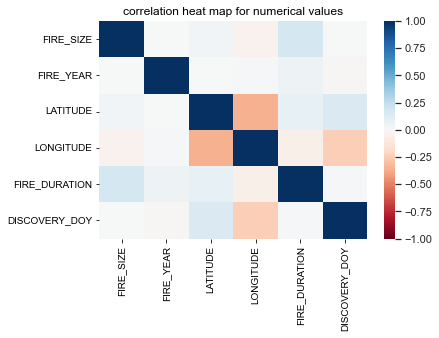

In [39]:
# Look at the correlation matrix
corr_mat = numericalFeatures.corr()
plt.title("correlation heat map for numerical values")
sns.set(rc={'figure.figsize':(8,6)})
s = sns.heatmap(corr_mat,cmap="RdBu",center=0,vmin=-1, vmax=1)

Linear Regression

In [40]:
# Let's try a model with only numerical data
scaler = StandardScaler()

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(numericalFeatures.drop(columns=[TARGET]),numericalFeatures[TARGET],test_size=.2,random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")
 
# The R2 and RMSE scores are not promising for predicting wildfire size. 
# Let's see if including one-hot encoded variables helps

R2 score: 0.025667121940842863 
RMSE: 7159755.375284318


Text(0.5, 1.0, 'Linear Regression with Numerical Data Only, Predicted vs Actual')

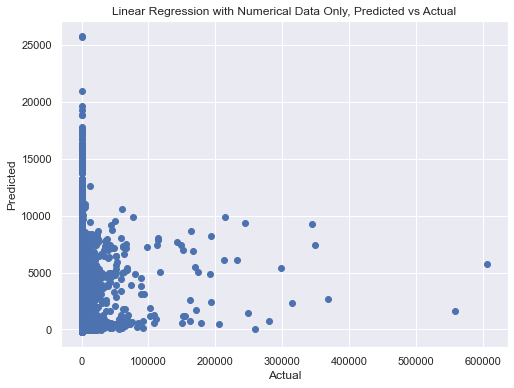

In [41]:
# visualize linear regression ran with numerical data only
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression with Numerical Data Only, Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Linear Regression including one-hot encoded categorical features

In [42]:
# Convert categorical data to numerical format using encoding methods.
wildfireSizeAnalysisDf = pd.get_dummies(wildfireSizeAnalysisDf, columns = ["STATE","STAT_CAUSE_DESCR", "OWNER_CODE"])

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(wildfireSizeAnalysisDf.drop(columns=[TARGET]),wildfireSizeAnalysisDf[TARGET],test_size=.2,random_state=SEED)

In [43]:
# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")

# This shows some improvement in test scores, but it is still not promising.

R2 score: 0.03130996631012051 
RMSE: 7118289.685051934


Text(0.5, 1.0, 'Linear Regression Predicted vs Actual')

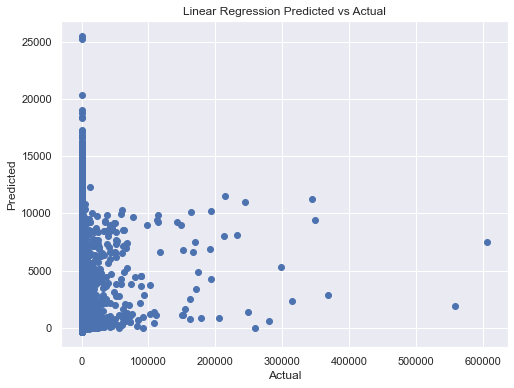

In [44]:
# visualize linear regression test results
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Random Forest Regression

In [45]:
#Try random forest regression!
#NOTE expect this cell to run for ~2 minutes!

#limit sample to 10,000 for time's sake
reg_rf = RandomForestRegressor(random_state=42, max_samples=10000)
reg_rf.fit(X_train,y_train)
y_pred = reg_rf.predict(X_test)

rRegScore=r2_score(y_test, y_pred)
rRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {rRegScore} \nRMSE: {rRegRMSE}")

R2 score: 0.0927841280577324 
RMSE: 7118289.685051934


Text(0.5, 1.0, 'Random Forest Regression Predicted vs Actual')

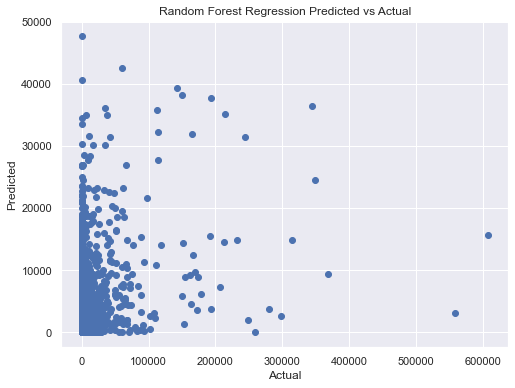

In [46]:
# visualize random forest regression results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression Predicted vs Actual")
# This shows some improvement over linear regression, however it is still not promising as it is not showing a pattern. Random forest regression is not a choice model for predicting wildfires.

Linear Regression Conclusion:

From the results above, for linear regression we see that linear regression is not sufficient to create a predictive model with the features "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY" to predict "FIRE_SIZE". 

Ultimately, the R2, RMSE scores are too low and Prediction vs. Actual plots show us that this does not make a trustworthy model of predicting fire size. In the Prediction vs. Actual plot we would like to see a direct linear trend with some variation and there is no direct relationship apparent.

Random Forest Regression offered some improvement in model performance. Further increasing the sampling size in random forest did not achieve meaningful increases in model accuracy at the expense of compute resources. Therefore it was deemed not necessary to run a long training with this model. The level of accuracy of this model, seen with the R2, RMSE, and Prediction vs. Actual plot also do not offer promising scores or a direct trend in the graph.

In order to improve model performance, we suggest further feature acquisition, particularly features related to weather. Joining wildfire data by county with weather data such as precipitation and wind speed and direction may improve the performance of this predictive model and offer more useful information.